In [1]:
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input
from keras.models import Model
import os
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import random

In [2]:
tf.config.run_functions_eagerly(True)
def set_seeds(seed=1299827):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

## 1. encode user info

In [3]:
names = ['occupations']
data_dir = "./data/ml-100k"
occupations = pd.read_csv(os.path.join(data_dir, 'u.occupation'), '\t', names=names,
                       engine='python')

<ipython-input-3-2ee378428c6a>:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  occupations = pd.read_csv(os.path.join(data_dir, 'u.occupation'), '\t', names=names,


In [4]:
names = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
data_dir = "./data/ml-100k"
user_info = pd.read_csv(os.path.join(data_dir, 'u.user'), '|', names=names,
                       engine='python')



<ipython-input-4-d55d9ac86324>:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  user_info = pd.read_csv(os.path.join(data_dir, 'u.user'), '|', names=names,


In [5]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df)))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size)
        ds = ds.prefetch(batch_size)
    return ds

def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

In [6]:
user_info.drop(columns=['user_id'], inplace=True)
gender = {'M': 0, 'F': 1}
user_info['gender'] = user_info['gender'].apply(lambda x: gender[x])

In [7]:
def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
        values.append(tf.cast(inputs[key], tf.float32))

    return fun(values, axis=-1)

In [8]:
binary_feature_names = ['gender']
categorical_feature_names = ['occupation', 'zip_code']
numeric_features = user_info[['age']]

inputs = {}
for name, column in user_info.items():
#     if type(column[0]) == str:
#         dtype = tf.string
    if (name in categorical_feature_names or
        name in binary_feature_names):
        dtype = tf.int64
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)


In [9]:
preprocessed = []

for name in binary_feature_names:
    inp = inputs[name]
    inp = inp[:, tf.newaxis]
    float_value = tf.cast(inp, tf.float32)
    preprocessed.append(float_value)

In [10]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

/home/seungjoonpark/miniconda3/envs/movielens/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [11]:
users = tf.convert_to_tensor(user_info['gender'].values, dtype=tf.float32)

In [12]:
users = tf.concat((users[:, tf.newaxis], tf.squeeze(normalizer(user_info['age'].values))[:, tf.newaxis]), axis=1)

In [13]:
numeric_inputs = {}
for name in ['age']:
    numeric_inputs[name]=inputs[name]

numeric_inputs = stack_dict(numeric_inputs)
numeric_normalized = normalizer(numeric_inputs)

preprocessed.append(numeric_normalized)

In [14]:
for name in categorical_feature_names:
    vocab = sorted(set(user_info[name]))
    print(f'name: {name}')
#     print(f'vocab: {vocab}\n')

    if type(vocab[0]) is str:
        lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot', num_oov_indices=0)
    else:
        lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot', num_oov_indices=0)

    x = lookup(user_info[name].values)
    users = tf.concat((users, x), axis=1)

name: occupation
name: zip_code


/home/seungjoonpark/miniconda3/envs/movielens/lib/python3.9/site-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [15]:
encoding_dim = 32
user_input = keras.Input(shape=(818,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(128, activation='leaky_relu')(user_input)
encoded = layers.Dense(64, activation='leaky_relu')(encoded)
encoded = layers.Dense(32, activation='leaky_relu')(encoded)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(64, activation='leaky_relu')(encoded)
decoded = layers.Dense(128, activation='leaky_relu')(decoded)
decoded = layers.Dense(818)(decoded)

user_autoencoder = keras.Model(user_input, decoded)
user_autoencoder.compile(optimizer='adam', loss='mse')

user_encoder = keras.Model(user_input, encoded)

# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_output = user_autoencoder.layers[-3](encoded_input)
decoder_output = user_autoencoder.layers[-2](decoder_output)
decoder_output = user_autoencoder.layers[-1](decoder_output)

# Create the decoder model
user_decoder = keras.Model(encoded_input, decoder_output)

user_autoencoder.compile(optimizer='adam', loss='mse')

In [16]:
latent_user = user_encoder.predict(users)

30/30 [==============================] - 0s 2ms/step


## 2. encode item info

In [8]:
from transformers import AutoTokenizer
from transformers import TFAutoModel
from keras.optimizers import Adam

/home/seungjoonpark/miniconda3/envs/movielens/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [18]:
names = ['movie_id', 'movie_title', 'release_date', 'video_release_date',
              'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
              "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
              "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
              "Thriller", "War", "Western"]
data_dir = "./data/ml-100k"
item_info = pd.read_csv(os.path.join(data_dir, 'u.item'), '|', names=names,
                       engine='python', encoding = "ISO-8859-1", index_col=False)

<ipython-input-18-5320d435494a>:7: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  item_info = pd.read_csv(os.path.join(data_dir, 'u.item'), '|', names=names,


In [19]:
item_info.drop(columns=['movie_id', 'video_release_date', 'IMDb_URL'], inplace=True)

In [20]:
item_info['movie_title'] = item_info['movie_title'].str.replace(r" \(\d{4}\)","")

<ipython-input-20-e4080aa4fef7>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  item_info['movie_title'] = item_info['movie_title'].str.replace(r" \(\d{4}\)","")


In [21]:
lm_input = tokenizer(item_info['movie_title'].values.tolist(), return_tensors='tf', truncation=True, padding=True, max_length=8)

In [22]:
model = TFAutoModel.from_pretrained("roberta-base")

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [23]:
lm_output = model.predict(lm_input)

/home/seungjoonpark/miniconda3/envs/movielens/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


53/53 [==============================] - 29s 539ms/step


In [27]:
items = tf.reshape(lm_output[0], (1682, -1))

In [28]:
item_info['release_year'] = item_info['release_date'].str.extract(r'(\d{4}$)')
item_info['release_year'] = item_info['release_year'].apply(lambda x: int(x) if pd.notnull(x) else x)

In [29]:
item_info['day_sin'] = np.sin(2 * np.pi * (pd.to_datetime(item_info['release_date']).dt.dayofyear/365.0))
item_info['day_cos'] = np.cos(2 * np.pi * (pd.to_datetime(item_info['release_date']).dt.dayofyear/365.0))

In [30]:
item_info.drop(columns=['release_date'], inplace=True)

In [31]:
item_info.fillna(item_info.mean(), inplace=True)

<ipython-input-31-18d38e6314db>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  item_info.fillna(item_info.mean(), inplace=True)


In [32]:
items = tf.concat((items, tf.convert_to_tensor(item_info.iloc[:, 1:19], dtype=tf.float32)),axis=1)

In [33]:
numeric_features = item_info.columns.tolist()

inputs = {}
for name, column in item_info.items():
#     if type(column[0]) == str:
#         dtype = tf.string
    if (name in categorical_feature_names or
        name in binary_feature_names):
        dtype = tf.int64
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)

NameError: name 'categorical_feature_names' is not defined

In [32]:
preprocessed = []

for name in numeric_features[:-3]:
    inp = inputs[name]
    inp = inp[:, tf.newaxis]
    float_value = tf.cast(inp, tf.float32)
    preprocessed.append(float_value)

In [33]:
numeric_inputs = {}
for name in ['release_year']:
    numeric_inputs[name]=inputs[name]

numeric_inputs = stack_dict(numeric_inputs)
numeric_normalized = normalizer(numeric_inputs)

preprocessed.append(numeric_normalized)

In [34]:
items = tf.concat((items, tf.squeeze(normalizer(item_info['release_year'].values))[:,tf.newaxis]), axis=1)

In [35]:
items = tf.concat((items, tf.convert_to_tensor(item_info.iloc[:,-2:], dtype=tf.float32)), axis=1)

In [36]:
for name in numeric_features[-2:]:
    inp = inputs[name]
    inp = inp[:, tf.newaxis]
    float_value = tf.cast(inp, tf.float32)
    preprocessed.append(float_value)

In [37]:
encoding_dim = 32
item_input = keras.Input(shape=(6165,))
# "encoded" is the encoded representation of the input
encoded = tf.keras.layers.BatchNormalization()(item_input)
encoded = layers.Dense(1024, activation='leaky_relu')(encoded)
encoded = layers.Dense(128, activation='leaky_relu')(encoded)
encoded = layers.Dense(32, activation='leaky_relu')(encoded)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(128, activation='leaky_relu')(encoded)
decoded = layers.Dense(1024, activation='leaky_relu')(decoded)
decoded = layers.Dense(6165)(decoded)


item_autoencoder = keras.Model(item_input, decoded)
item_autoencoder.compile(optimizer='adam', loss='mse')

item_encoder = keras.Model(item_input, encoded)

# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_output = item_autoencoder.layers[-3](encoded_input)
decoder_output = item_autoencoder.layers[-2](decoder_output)
decoder_output = item_autoencoder.layers[-1](decoder_output)

# Create the decoder model
item_decoder = keras.Model(encoded_input, decoder_output)

In [38]:
item_autoencoder.compile(optimizer='adam', loss='mse')

In [96]:
latent_item = item_encoder.predict(items)

 7/53 [==>...........................] - ETA: 0s

/home/seungjoonpark/miniconda3/envs/movielens/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


53/53 [==============================] - 1s 10ms/step


In [42]:
item_decoder.predict(latent_item)[0][0]

53/53 [==============================] - 0s 5ms/step


-0.010685469

## User-Item match dataset

In [52]:
user_ids = []
item_ids = []
ratings = []
timestamps = []

with open("./data/ml-100k/u.data", 'rt') as file1:
    for line in file1.readlines():
        a = line.split()
        user_ids.append(a[0])
        item_ids.append(a[1])
        ratings.append(a[2])
        timestamps.append(a[3])
    
rating_df = pd.DataFrame({'user_id': user_ids, 'item_id': item_ids, 'rating': ratings, 'timestamp': timestamps})
rating_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [91]:
clicked = {1: 0., 2: 0., 3: 0., 4: 1., 5: 1.}
rating_df['rating']=rating_df['rating'].apply(lambda x: clicked[int(x)])

In [74]:
# tf.map_fn(tf.one_hot, tf.convert_to_tensor(rating_df['rating'].values))

In [75]:
# sigmoid = lambda x: 1/(1 + np.exp(-x))

In [76]:
# rating_similarity = {1: sigmoid(-4.), 2: sigmoid(-2.), 3: sigmoid(0.), 4: sigmoid(2.), 5: sigmoid(4.)}

In [77]:
# rating_df['rating']=rating_df['rating'].apply(lambda x: rating_similarity[int(x)])

In [78]:
rating_df.drop(columns=['timestamp'], inplace=True)

In [79]:
rating_df['user_id'] = rating_df['user_id'].astype(int)-1
rating_df['item_id'] = rating_df['item_id'].astype(int)-1

In [80]:
user = tf.gather(users, rating_df.user_id.values)
item = tf.gather(items, rating_df.item_id.values)

In [81]:
# dataset = tf.data.Dataset.from_tensor_slices((user, item, tf.convert_to_tensor(rating_df['rating'].values)))

In [83]:
user_input = Input(shape=(818,))
item_input = Input(shape=(6165,))
user_feat = user_encoder(user_input)
user_encoder.trainable = False
# reordering layer
user_feat = layers.Dense(32)(user_feat)
item_feat = item_encoder(item_input)
item_encoder.trainable = False
# reordering layer
item_feat = layers.Dense(32)(item_feat)
outputs = tf.keras.layers.Dot(axes=1)([user_feat, item_feat])
outputs =  tf.keras.activations.sigmoid(outputs)

In [84]:
model = Model(inputs=[user_input, item_input], outputs=outputs)

In [85]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=200,
    decay_rate=0.96,
    staircase=True)

In [101]:
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
	metrics=["accuracy"])

In [102]:
model.load_weights('./checkpoints/score_model_cross')

In [103]:
user_encoder = keras.Model(user_input, user_feat)
item_encoder = keras.Model(item_input, item_feat)

In [89]:
user_encoder(users)

<tf.Tensor: shape=(943, 32), dtype=float32, numpy=
array([[ 0.06471726,  0.14580399, -0.04886822, ..., -0.06411254,
        -0.05549216,  0.03660396],
       [-0.01825669,  0.16883862, -0.02001277, ..., -0.09270785,
        -0.0853997 ,  0.09662438],
       [ 0.2329463 , -0.06012689,  0.05843551, ..., -0.18792096,
         0.11835526,  0.05206817],
       ...,
       [-0.07993348,  0.18968599,  0.09113791, ..., -0.05886102,
         0.0343435 , -0.03377326],
       [ 0.05947705,  0.24741687,  0.04941652, ..., -0.01677305,
        -0.07202731,  0.06945418],
       [ 0.0538527 ,  0.11295451,  0.08264452, ..., -0.00058282,
         0.1939039 , -0.10428812]], dtype=float32)>

In [90]:
user_latent = np.load('user2.npy')

In [106]:
item_encoder.load_weights('./checkpoints/item_encoder_cross')

In [105]:
temp = item_encoder.predict(items)

53/53 [==============================] - 0s 7ms/step


In [97]:
item_latent = np.load('item2.npy')

In [107]:
item_encoder.predict(items) == temp

53/53 [==============================] - 0s 6ms/step


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [108]:
temp2 = user_encoder.predict(users)

30/30 [==============================] - 0s 2ms/step


In [109]:
user_encoder.load_weights('./checkpoints/user_encoder_cross')

In [110]:
user_encoder.predict(users) == temp2

30/30 [==============================] - 0s 2ms/step


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [100]:
user_latent = np.load('user2.npy')

In [102]:
user_encoder.load_weights('./checkpoints/user_encoder_cross')

In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [58]:
user_features = np.load('con_user.npy')

In [59]:
utsne = TSNE(n_components=2).fit_transform(user_features)

In [4]:
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

In [61]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = utsne[:, 0]
ty = utsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

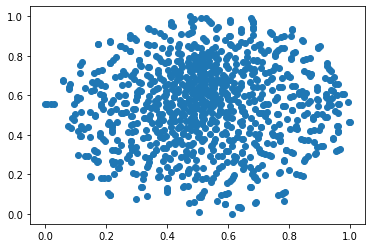

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(tx, ty)

In [24]:
item_features = np.load('con_item_final2.npy')
itsne = TSNE(n_components=2).fit_transform(item_features)
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = itsne[:, 0]
ty = itsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [25]:
genres = ['unknown', 'Action', 'Adventure', 'Animation',
              "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
              "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
              "Thriller", "War", "Western"]

In [36]:
labels = item_info.iloc[:, 1:20].idxmax(axis=1)

In [37]:
item_features = np.load('con_item_final2.npy')
itsne = TSNE(n_components=2).fit_transform(item_features)
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = itsne[:, 0]
ty = itsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [38]:
cm = plt.cm.get_cmap('tab20')

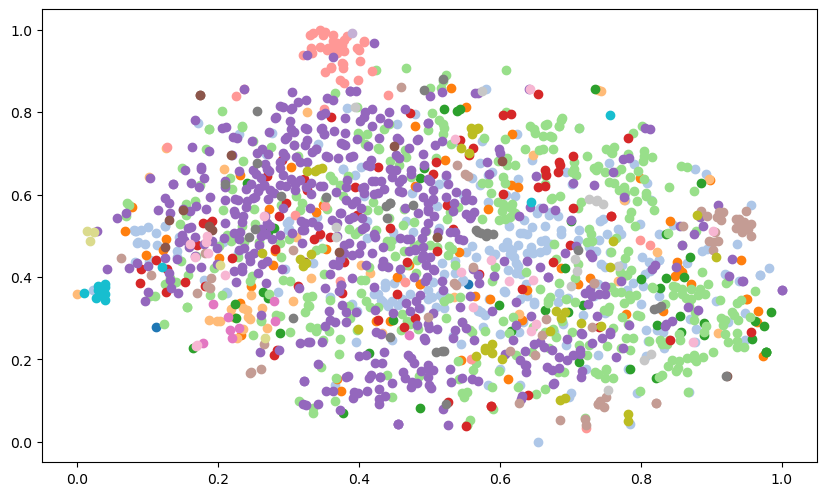

In [39]:
# initialize a matplotlib plot
fig = plt.figure(figsize=(10, 6), dpi=100)
ax = fig.add_subplot(111)



# # for every class, we'll add a scatter plot separately
for idx, label in enumerate(genres):
#     if label in ['Fantasy', 'Crime']:
#         continue
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
#     color = np.array(colors_per_class[label], dtype=np.float) / 255
 
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, label=label, color=cm.colors[idx])
 
# build a legend using the labels we set previously
# ax.legend(loc='best')



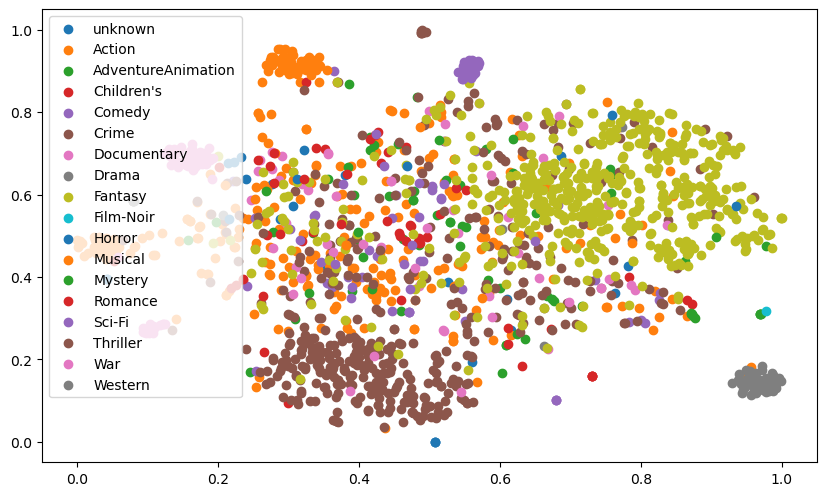

In [104]:
# initialize a matplotlib plot
fig = plt.figure(figsize=(10, 6), dpi=100)
ax = fig.add_subplot(111)



# # for every class, we'll add a scatter plot separately
for label in genres:
#     if label in ['Fantasy', 'Crime']:
#         continue
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
#     color = np.array(colors_per_class[label], dtype=np.float) / 255
 
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, label=label)
 
# build a legend using the labels we set previously
ax.legend(loc='best')


In [121]:
item_encoder.load_weights('./checkpoints/item_encoder_cross')

ValueError: Received incompatible tensor with shape (32,) when attempting to restore variable with shape (1024,) and name layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE.

In [57]:
tf.math.sigmoid(model.predict([user[:8], item[:8]]))

1/1 [==============================] - 0s 114ms/step


<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[0.81873375],
       [0.7829724 ],
       [0.11172543],
       [0.69215775],
       [0.5426289 ],
       [0.836669  ],
       [0.5364756 ],
       [0.8023394 ]], dtype=float32)>

In [63]:
rating_df['rating'][:8]

0    0.500000
1    0.500000
2    0.017986
3    0.119203
4    0.017986
5    0.880797
6    0.119203
7    0.982014
Name: rating, dtype: float64